# PCA for SFU Hyperspectral Set (2002)

### Цель работы

Изучить спектры отражательных способностей (окрасок) из набора SFU Hyperspectral Set (K. Barnard et all, 2002) путем применения PCA.

### План работы
1. Рассмотреть собственные числа матрицы данных, а также собственные вектора (главные компоненты) в виде конкретных спектров. 
2. Применить PCA к набору данных.
3. Получить аппроксимации функций отражательной способности при различном числе главных компонент.
4. Изучить поведение ошибок.

Цели и задачи данного исследования во многом повторяют предыдущие работы:
* J. Cohen - "Dependency of the spectral reflectance curves of the Munsell color chips" (1964)
* J.P.S. Parkkinen et all - "Characteristic spectra of Munsell colors" (1989)
* H.S. Fairman, M.H. Brill - "The Principal Components of Reflectances" (2003)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Чтение и обзор данных

Barnard: "All the spectra consist of 101 measurements from 380 nm to 780 nm in steps of 4 nm".

In [2]:
grid = np.arange(380, 781, 4)

In [3]:
def read_data(name_set, size_set):
    data = []

    with open(name_set, 'r') as reader:
        for line in reader:
            line = line.split('#')[0].split()
            if line != []:
                data.append(line)
        
    return pd.DataFrame(np.array(data).astype(np.float)
                        .reshape(size_set, grid.size), columns=grid)

`reflect`: 1995 $\times$ 101 table based on the set of 1995 spectra (24 Macbeth, 1269 Munsell, 120 Dupont, 170 natural objects, 350 Krinov, 57 Barnard).

In [4]:
reflect = read_data('reflect_db.reflect', 1995)
reflect.head()

380       384       388       392       396       400       404  \
0  0.074541  0.088587  0.114740  0.153970  0.204740  0.256720  0.309150   
1  0.031178  0.035267  0.046950  0.061901  0.083274  0.104330  0.125520   
2  0.134050  0.117120  0.109440  0.100790  0.098923  0.091811  0.087962   
3  0.275870  0.290180  0.311960  0.338260  0.362380  0.389810  0.424700   
4  0.076024  0.070393  0.061676  0.055570  0.052111  0.052317  0.048871   

        408       412       416  ...       744       748       752      756  \
0  0.355750  0.388340  0.406270  ...  0.205730  0.260570  0.326440  0.40305   
1  0.145550  0.159680  0.166150  ...  0.044793  0.061372  0.088872  0.13120   
2  0.085504  0.082288  0.083102  ...  0.782970  0.783360  0.782670  0.78380   
3  0.467000  0.513040  0.553160  ...  0.463230  0.488760  0.513820  0.53685   
4  0.047319  0.047332  0.044628  ...  0.868880  0.868820  0.869310  0.87073   

       760      764      768      772      776      780  
0  0.47676  0.53370  0.57906  0.61773  0.63978  0.65621  
1  0.18150  0.22723  0.26845  0.30647  0.33058  0.34906  
2  0.78534  0.78293  0.78111  0.77907  0.77754  0.77529  
3  0.55588  0.56880  0.57862  0.58670  0.59188  0.59783  
4  0.86973  0.86902  0.86750  0.86483  0.86232  0.86272  

[5 rows x 101 columns]

Приведённый ниже график не информативен, но дает представление о разнообразии спектров в наборе данных.

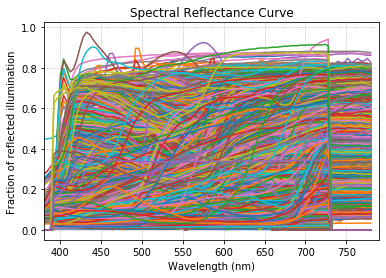

In [5]:
for i in range(1995):
    plt.plot(grid, reflect.loc[i].values)
                                                        
plt.title('Spectral Reflectance Curve')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Fraction of reflected illumination')
    
plt.xlim(380,790)
plt.grid(ls=':')
plt.show()

### Нормализация и центрирование

В качестве необходимого масштабирования данных рассмотрим два варианта - нормализацию и центрирование. В последнем случае значения в выборке не делятся на стандартное отклонение.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

normalizer = StandardScaler().fit(reflect)
centering = StandardScaler(with_std=False).fit(reflect)

reflect_normal = pd.DataFrame(normalizer.transform(reflect))
reflect_centr = pd.DataFrame(centering.transform(reflect))

pca_normal = PCA(svd_solver='full').fit(reflect_normal)
pca_centr = PCA(svd_solver='full').fit(reflect_centr)

### Собственные числа и собственные векторы. Explained variance. Сравнение со средним

Расммотрим собственные (здесь - сингулярные) числа матрицы данных. Также проследим за поведением explained variance curve.

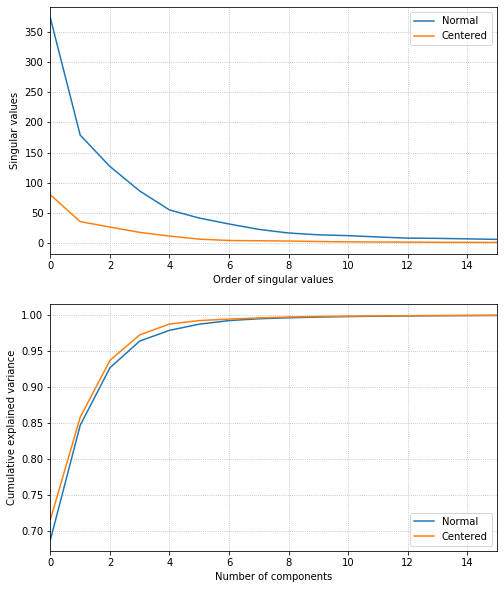

In [7]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 10))

ax1.plot(pca_normal.singular_values_, label='Normal')
ax1.plot(pca_centr.singular_values_, label='Centered')
ax1.set_xlim(0, 15)

ax1.set_xlabel('Order of singular values')
ax1.set_ylabel('Singular values')
ax1.grid(ls=':')
ax1.legend()


ax2.plot(np.cumsum(pca_normal.explained_variance_ratio_), label='Normal')
ax2.plot(np.cumsum(pca_centr.explained_variance_ratio_), label='Centered')
ax2.set_xlim(0, 15)

plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
ax2.grid(ls=':')
ax2.legend()

plt.show()

Из второго графика хорошо видно, что уже по трём компонентам можно достатчно точно аппроксимировать любой спектр из набора данных, однако значения первых шести-восьми сингулярных чисел относительно значимы. С точки зрения второго графика при таком числе компонент практически вся информация о данных будет сохранена. Очевидно, что наибольший интерес представляет рассмотрение аппроксимаций в этом диапазоне.

Также, первый график демонстрирует значительно меньшее количество выраженных собственных чисел для случая центрированной выборки, нежели для нормализованой. Второй график показывает, что главные компоненты центрированных выборок содержат больше информации о данных. Это объясняется тем, что разброс порядков изнчальных данных относительно невелик, а значит производить масштабирование посредством стандартного отклонения не имеет смысла. Далее будем работать только с центрированными данными.

In [8]:
components_centr = pd.DataFrame(pca_centr.components_)

Получим среднее значение функций отражательной способности для всех длин волн. Назовём это средним спектром.

In [9]:
reflect_mean = reflect.mean()

На следующем графике построены первые три главные компоненты центрированных данных, а также средний спектр.

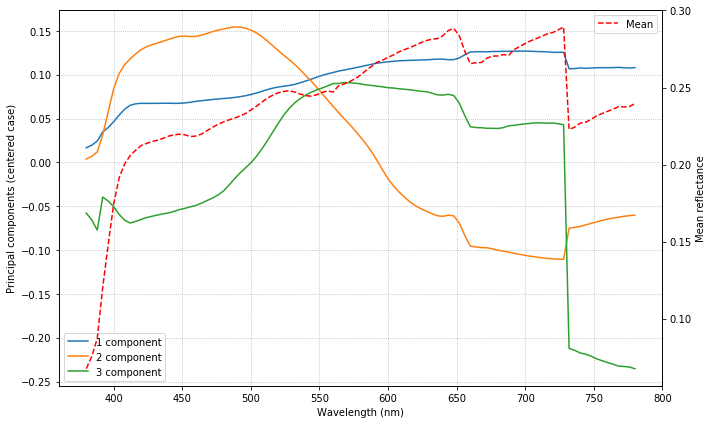

In [10]:
fig, ax1 = plt.subplots(figsize=(10, 6))

for i in range(3):
    ax1.plot(reflect_mean.index, 
             components_centr.loc[i].values, label='{} component'.format(i+1))
    
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Principal components (centered case)')
ax1.legend()
ax1.grid(ls=':')

ax2 = ax1.twinx()
ax2.plot(reflect_mean.index, reflect_mean.values, '--', color='r', label='Mean')

ax2.set_ylabel('Mean reflectance')
ax2.legend()

fig.tight_layout()
plt.title('')
plt.show()

В целом, средний спектр по форме походит на первую компоненту, что согласуется с предыдущими результатами (см. упомянутые в начале статьи).

Плоскостность (flatness) первой компоненты свидетельствует о равномерном и плотном покрытии графика функций отражательных спосбностей, что было видно и ранее.

### Трёхмерный график

Cohen (1964): "First three componets plot as a near-perfect helix (it is best to plot axes II and III, and visualize I), where complementary wavelengths seem to be opposite each other."

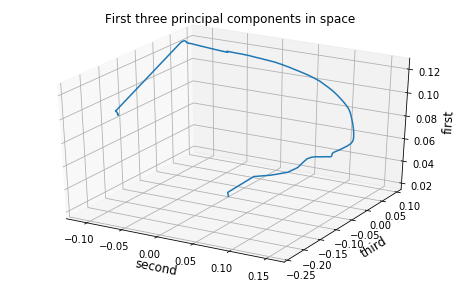

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 5))
ax = fig.gca(projection='3d')
ax.plot(components_centr.loc[1].values, 
        components_centr.loc[2].values, 
        components_centr.loc[0].values)

ax.set_xlabel('second', fontsize=12)
ax.set_ylabel('third', fontsize=12)
ax.set_zlabel('first', fontsize=12)

plt.title('First three principal components in space')
plt.show()

Как видим, "perfect", пусть даже и "near", спираль не наблюдается. О неактуальности результатов Коэна и заведомых неточностях в его методе см. те же статьи Парккинена и Фэйрмана.

Справедливости ради отметим, что Коэн работал только с набором красок Манселла и с гораздо более редкой сеткой.

### Аппроксимация

Эта функция выдает значения аппроксимированных функций отражательной способности в том же виде, что и изначальные данные.

In [12]:
def get_approximation(num_components):
    pca = PCA(n_components=num_components, svd_solver='full')
    reflect_transform = pca.fit_transform(reflect_centr)

    return pd.DataFrame(centering.inverse_transform
                        (pca.inverse_transform(reflect_transform)))

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [14]:
def plot_approx_spectrum(num_spectrum):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    true = reflect.loc[num_spectrum].values
    
    for i, ax in zip(range(4), axs.reshape(-1)):
        approx = approximations[i].loc[num_spectrum].values
        if i == 0:
            ax.plot(grid, true, label='Original')
            ax.plot(grid, approx, '--', color='r', label='Approximation')
        else:
            ax.plot(grid, true)
            ax.plot(grid, approx, '--', color='r')
        ax.set_title('{} components'.format(4 + 2*i))
        ax.grid(ls=':')
        print('{} components RMSE: '.format(4 + 2*i), round(sqrt(mean_squared_error(true, approx)), 5))
        print('{} components MAE: '.format(4 + 2*i), round(mean_absolute_error(true, approx), 5))
        print()
                 
    axs[0][0].set_ylabel('Reflectance')
    axs[1][0].set_ylabel('Reflectance')
    axs[1][0].set_xlabel('Wavelength (nm)')
    axs[1][1].set_xlabel('Wavelength (nm)')
                 
    fig.suptitle('Spectrum №{}'.format(num_spectrum), fontsize=16)
    fig.legend()
    plt.show()

In [15]:
approximations = [get_approximation(4),
                 get_approximation(6),
                 get_approximation(8),
                 get_approximation(10)]

Посмотрим на аппроксимацию каких-нибудь спектров при разном числе главных компонент.

4 components RMSE:  0.07522
4 components MAE:  0.04978

6 components RMSE:  0.06879
6 components MAE:  0.04137

8 components RMSE:  0.06448
8 components MAE:  0.03831

10 components RMSE:  0.05598
10 components MAE:  0.03072



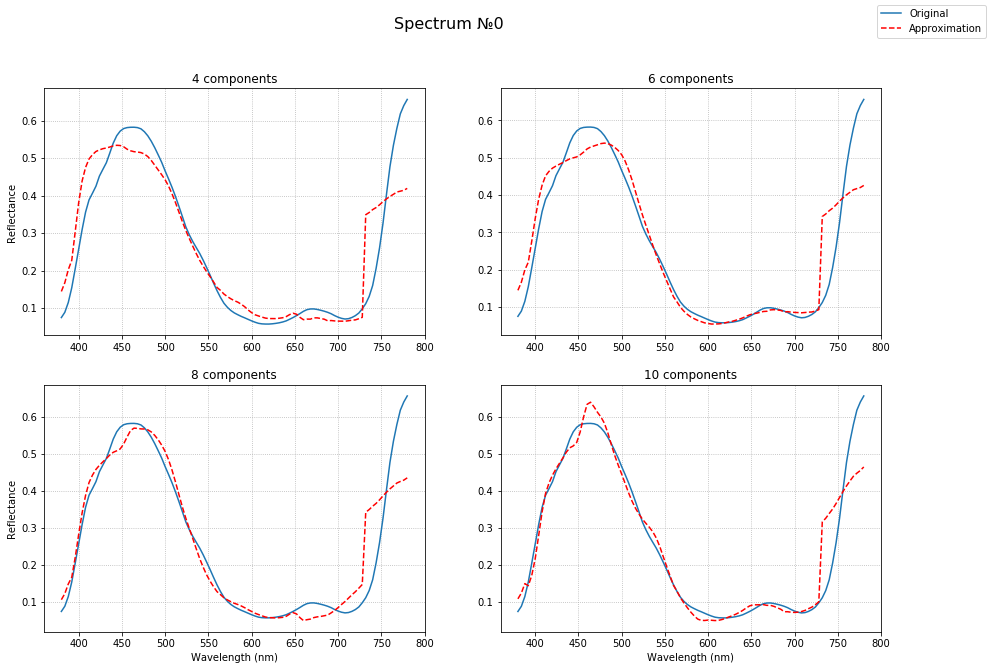

In [16]:
plot_approx_spectrum(0)

4 components RMSE:  0.01738
4 components MAE:  0.01258

6 components RMSE:  0.01515
6 components MAE:  0.01082

8 components RMSE:  0.01311
8 components MAE:  0.00939

10 components RMSE:  0.01142
10 components MAE:  0.00761



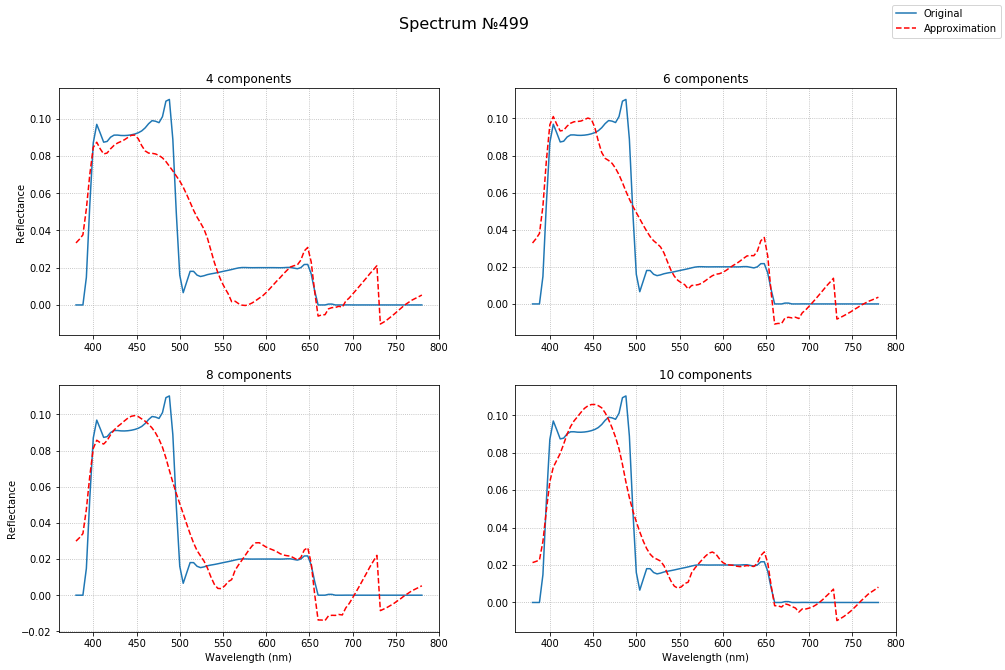

In [17]:
plot_approx_spectrum(499)

4 components RMSE:  0.00732
4 components MAE:  0.00523

6 components RMSE:  0.00563
6 components MAE:  0.00362

8 components RMSE:  0.00273
8 components MAE:  0.00204

10 components RMSE:  0.00229
10 components MAE:  0.00171



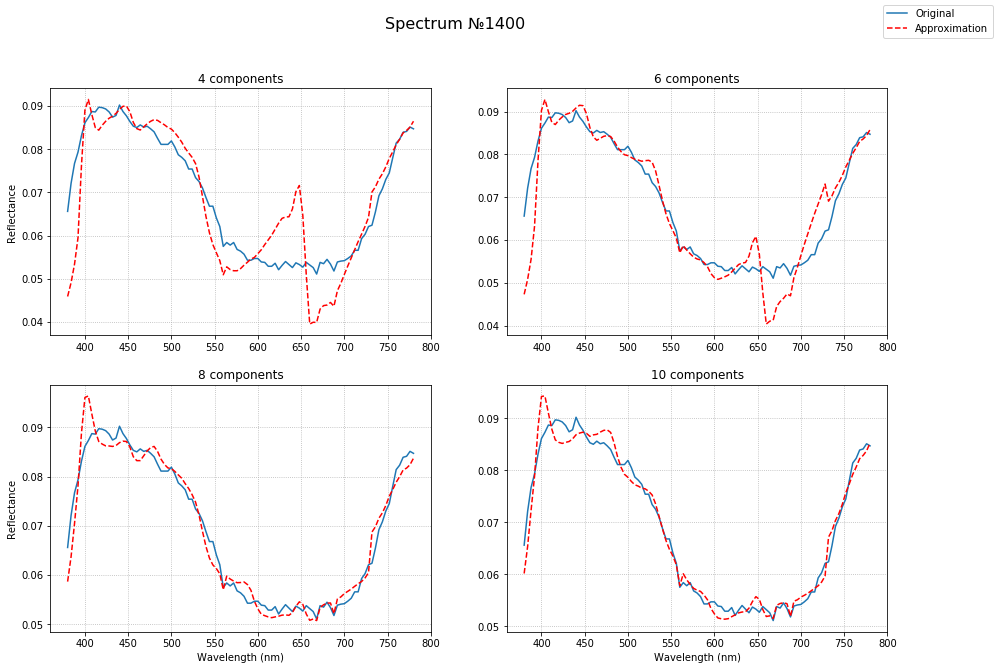

In [18]:
plot_approx_spectrum(1400)

4 components RMSE:  0.05401
4 components MAE:  0.03467

6 components RMSE:  0.03727
6 components MAE:  0.02398

8 components RMSE:  0.02415
8 components MAE:  0.01895

10 components RMSE:  0.01402
10 components MAE:  0.00974



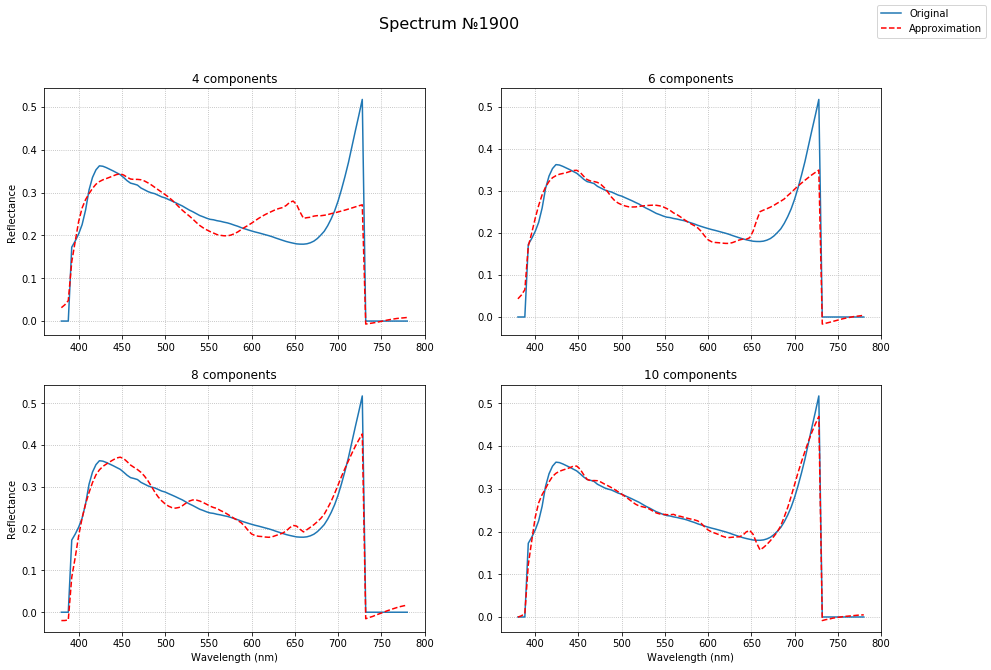

In [19]:
plot_approx_spectrum(1900)

Заметим, что вышеприведенные графики подтверждают факт различной природы исходных спектров в разных частях набора данных.

### Исследование ошибок

Рассчитаем  RMSE и MAE для аппроксимированных спектров при разном числе компонент, усредняя по всем спектрам или беря максимум.

In [20]:
errors = [[],[],[],[]] #RMSE avrg, RMSE max, MAE avrg, MAE max

for i in range(3, 13):
    root_mean_square_errors = []
    mean_absolute_errors = []
    
    approxs = get_approximation(i)
    for j in range(1995):
        root_mean_square_errors.append(sqrt(
            mean_squared_error(reflect.loc[j].values, approxs.loc[j].values)))
        mean_absolute_errors.append(
            mean_absolute_error(reflect.loc[j].values, approxs.loc[j].values))
    
    root_mean_square_errors = np.array(root_mean_square_errors)
    mean_absolute_errors = np.array(mean_absolute_errors)
    
    errors[0].append(root_mean_square_errors.mean())
    errors[1].append(root_mean_square_errors.max())
    errors[2].append(mean_absolute_errors.mean())
    errors[3].append(mean_absolute_errors.max())
    
errors = pd.DataFrame(np.array(errors).T, index=np.arange(3, 13), 
             columns=['Average RMSE', 'Maximum RMSE', 'Average MAE', 'Maximum MAE'])

In [21]:
errors

Average RMSE  Maximum RMSE  Average MAE  Maximum MAE
3       0.042138      0.268142     0.035216     0.253321
4       0.027754      0.181401     0.021553     0.137726
5       0.019414      0.139984     0.014415     0.101801
6       0.015387      0.097418     0.010856     0.064812
7       0.013122      0.082255     0.009151     0.052970
8       0.011005      0.082254     0.008090     0.052929
9       0.009006      0.073502     0.006515     0.045371
10      0.007569      0.068307     0.005319     0.041002
11      0.006668      0.063388     0.004688     0.038824
12      0.005837      0.060399     0.004069     0.034913

Построим графики зависимости рассчитанных ошибок от числа компонент.

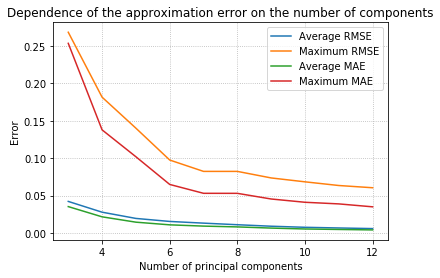

In [22]:
plt.plot(errors.index, errors.T.iloc[0].values, label='Average RMSE')
plt.plot(errors.index, errors.T.iloc[1].values, label='Maximum RMSE')
plt.plot(errors.index, errors.T.iloc[2].values, label='Average MAE')
plt.plot(errors.index, errors.T.iloc[3].values, label='Maximum MAE')

plt.title('Dependence of the approximation error on the number of components')
plt.ylabel('Error')
plt.xlabel('Number of principal components')

plt.legend()
plt.grid(ls=':')
plt.show()

Рассчитаем отклонения (не используя модуля) аппроксимаций.

In [23]:
non_absolute_error_on_wave = np.array([
                               reflect.T.values - approximations[0].T.values, #4 компоненты
                               reflect.T.values - approximations[1].T.values, #6
                               reflect.T.values - approximations[2].T.values, #8
                               reflect.T.values - approximations[3].T.values]) #10

Для каждой длины волны, данной по сетке, найдем границы диапазона отклонений от изначальных данных.

In [24]:
max_non_absolute_error_on_wave = [[],[],[],[]]
min_non_absolute_error_on_wave = [[],[],[],[]]

for i in range(4):
    for j in range(101):
        max_non_absolute_error_on_wave[i].append(
            non_absolute_error_on_wave[i][j].max())
        min_non_absolute_error_on_wave[i].append(
            non_absolute_error_on_wave[i][j].min())

Визуализируем это. Аналогичный график можно найти у Парккинена.

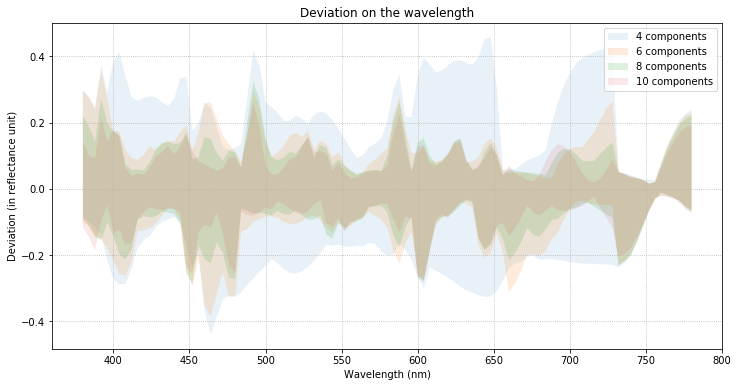

In [25]:
plt.figure(figsize=(12, 6))

plt.fill_between(grid, min_non_absolute_error_on_wave[0],
                 max_non_absolute_error_on_wave[0], label='4 components', alpha=0.10)
plt.fill_between(grid, min_non_absolute_error_on_wave[1],
                 max_non_absolute_error_on_wave[1], label='6 components', alpha=0.15)
plt.fill_between(grid, min_non_absolute_error_on_wave[2],
                 max_non_absolute_error_on_wave[2], label='8 components', alpha=0.15)
plt.fill_between(grid, min_non_absolute_error_on_wave[3],
                 max_non_absolute_error_on_wave[3], label='10 components', alpha=0.10)

plt.title('Deviation on the wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Deviation (in reflectance unit)')
plt.legend()
plt.grid(ls=':')
plt.show()

При различном числе компонент отклонения сохраняют относительную величину (магнитуду) при каждой длине волны. При увеличении числа главных компонент полоса становится **у**же и почти (т.е. не всегда) полностью вложена в полосы, соответствующие меньшим количествам компонент. Зависимости между шириной полосы и длинами волн, как и следовало ожидать, не обнаружено, однако в длинноволновом диапазоне наблюдается резкое значительное сужение полос.

Наконец, построим гистрограммы для распределения отклонений при конкретных длинах волн, но с разным числом компонент. Это имеет смысл потому, что зависимости ошибок от длин волн не обнаружено, а значит можно предположить, что все распределения будут принадлежать одному семейству. Однако эта гипотеза требует более строгой статистической проверки.

In [26]:
def approx_hist(wavelength):
    assert len(np.where(grid == 380)[0])
    
    n_bins = 150
    fig, axs = plt.subplots(2, 2, figsize=(9, 9))
    
    for i, ax in zip(range(4), axs.reshape(-1)): 
        ax.hist(pd.DataFrame(non_absolute_error_on_wave[i],
                             index=grid).loc[wavelength].values, bins=n_bins)
        ax.set_xlim(-0.1, 0.1)
        ax.set_title('{} components'.format(4 + 2*i))
    
    axs[0][0].set_ylabel('Number of spectra')
    axs[1][0].set_ylabel('Number of spectra')
    axs[1][0].set_xlabel('Deviation')
    axs[1][1].set_xlabel('Deviation')
    
    fig.suptitle('{} nm'.format(wavelength), fontsize=16)
    plt.show()

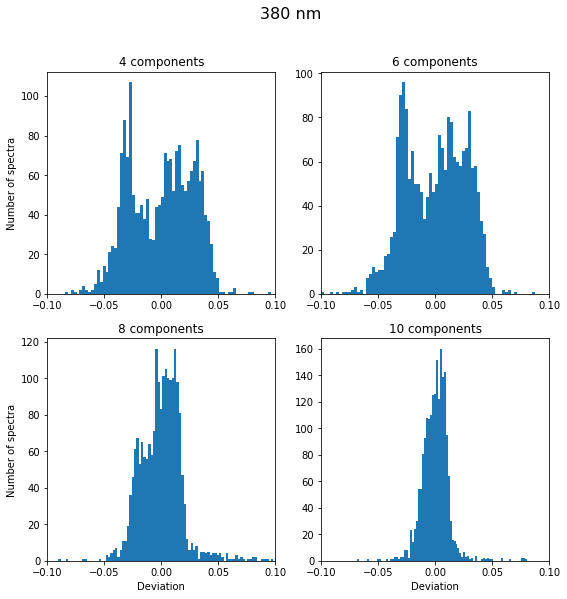

In [27]:
approx_hist(380)

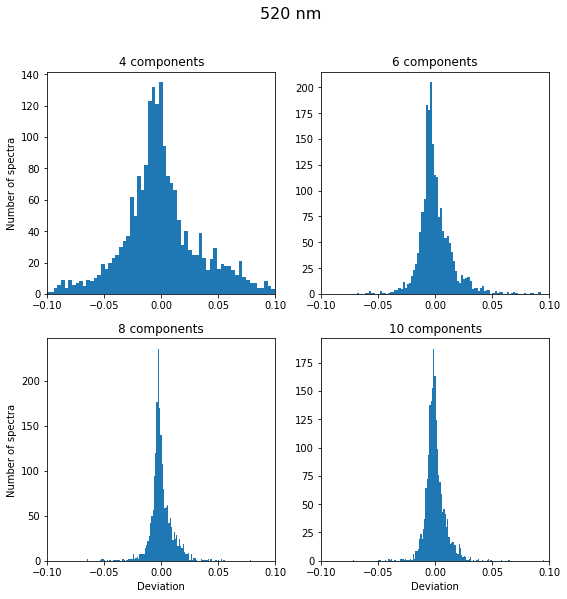

In [28]:
approx_hist(520)

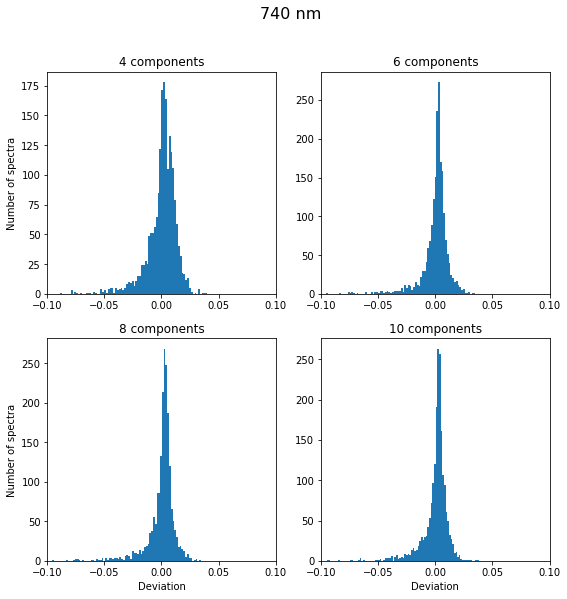

In [29]:
approx_hist(740)

### Анализ результатов

В результате проделанной работы:

1. Были рассмотрены два случая предобработки данных. Анализ значений собственных чисел выявил преимущества центрирования перед нормализацией при работе с данным набором спектров.

2. Был определён диапазон числа компонентов (от 4 до 8), дающий наиболее точное приближение к реальным данным. 

3. С помощью PCA были получены собственные векторы (главные компоненты) набора данных. Был построен график первых трёх компонент в сравнении со средним значением спектра. Обнаружено, что первая компонента отражает разнообразие спектров и походит на среднее.

4. Было проверено утверждение Коэна о том, что первые три главные компоненты при визуализации 2-й и 3-й образуют спираль. Гипотеза в данном исследовании не подтверждена. В поздних работах это не вызывало интереса.

5. Были построены графики и вычислены ошибки приближенных функций отражательной способности в сравнении с оригинальными для разного числа главных компонент аппроксимации. Было выбрано несколько спектров, скорее всего различных по своей природе.

6. Вычислены ошибки (максимумы RMSE и MAE, а также их средние значения по всем спектрам) для разного числа компонент, построены графики зависимостей. Как и следовало ожидать, аппроксимация происходит лучше при увеличении числа компонент.

7. Дополнительно исследованы отклонения при конкретной длине волны для всех спектров. Построены области ошибок, визуализированы распределения отклонений для разных длин волн.

В целом, результаты работы были практически полностью предсказуемы и повторяют упомянутые в начале. Тем важнее было убедиться в актуальности предыдущих исследований.